# Overview of concepts

In [1]:
# Imports 
import numpy as np 
from matplotlib import pyplot 
%matplotlib inline

## 1/f noise 

The most commonly encountered form of noise is white-noise. White-noise describes random, gaussian distributed variations that have all the typical statistical properties you might expect. For example for a set of random variables $x$ drawn from a white noise distribution the mean is 
$$
\left<x\right> = \frac{\sum{x}}{N}, 
$$
and the variance is 
$$
\sigma^2 = \left<x^2\right> - \left<x\right>^2 
$$
If you were to measure the power spectrum of $x$ (by taking the sqaure of the fourier transform) you would find that the power spectrum is flat. This is the example shown in the third plot below where $alpha = 0$. 

1/f noise is a more general description for noise. It describes noise that have power spectra that can be described as 
$$
P(\nu) = \sigma^2 \left(\frac{\nu}{\nu_k}\right)^\alpha, 
$$
where $alpha$ is the spectral index ($alpha = 0$ is white noise), $\sigma^2$ is the variance of the noise as the fourier frequency $\nu_k$. If you generate noise with $\alpha <0$ you get correlations between the samples of $x$. Some interesting properties of this noise is that the variance is $\sigma^2 = \infty$ at $N = \infty$, which means that as $N$ increases, the variance will increase.

Referenecs:
- Chapter 4 of Tools of Radio Astronomy
- 1/f noise and other systematic effects in the Planck-LFI radiometers: https://arxiv.org/abs/astro-ph/0206093 

[<Axes: > <Axes: > <Axes: > <Axes: > <Axes: > <Axes: >]


/Users/user/.pyenv/versions/3.11.6/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/user/.pyenv/versions/3.11.6/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


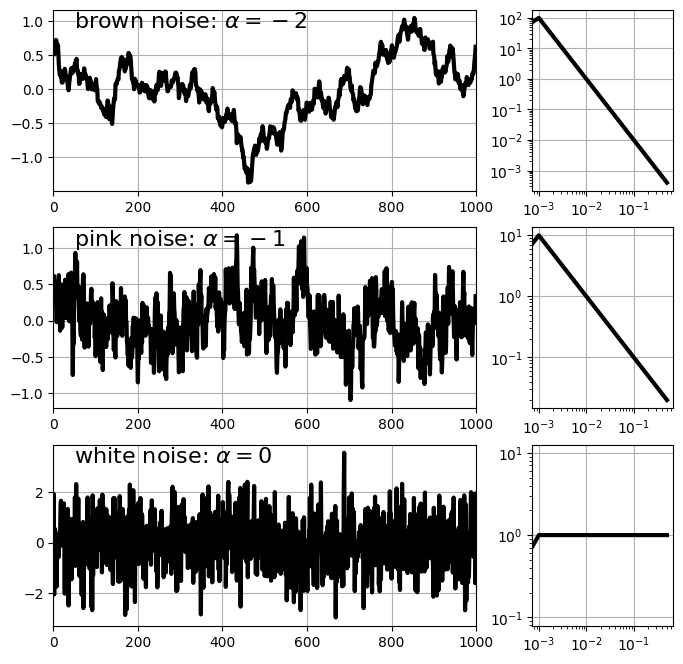

In [2]:
def generate_fnoise(alpha, rms=1, N=1000, nu0=1):
    """Generate 1/f noise 
    
    alpha - spectral index of noise
    """
    wn = np.random.normal(size=N, scale=rms)

    # Fourier transform white noise
    f_wn = np.fft.fft(wn)
    nu = np.fft.fftfreq(N)
    
    power_spectrum = np.zeros_like(f_wn)

    # Avoid division by zero, ignore index 0
    power_spectrum[1:] = np.abs(nu[1:]/nu0)**(alpha) 

    # Multiply white noise by sqrt of power spectrum
    f_noise = f_wn * power_spectrum**0.5

    # Inverse Fourier transform
    noise = np.fft.ifft(f_noise)

    ps = power_spectrum[:N//2]
    nu = nu[:N//2]
    return noise.real, nu, ps 

alphas = [-2,-1,0]
names  = ['brown','pink','white']

fig, axes = pyplot.subplots(3,2,width_ratios=[3, 1],figsize=(8,8))
axes = axes.flatten()
print(axes)

for i, (alpha, name) in enumerate(zip(alphas, names)):
    noise, nu, ps = generate_fnoise(alpha,nu0=0.01)
    pyplot.sca(axes[2*i])
    pyplot.plot(noise, 'k', lw=3)
    pyplot.grid() 
    pyplot.text(0.05, 0.9, r'{} noise: $\alpha = {}$'.format(name, alpha), transform=pyplot.gca().transAxes, fontsize=16)
    pyplot.xlim(0,noise.size)
    pyplot.sca(axes[2*i+1])
    pyplot.plot(nu, ps, 'k', lw=3)
    pyplot.grid() 
    pyplot.xscale('log')
    pyplot.yscale('log') 

pyplot.show()

## Origin of 1/f noise in COMAP

1/f noise in a total power radiometer like COMAP comes from two sources: 
1) The low noise amplifiers (LNAs)
2) Fluctuations in the water column (preciptable water vapour - pwv) above the telescope. 

Generally speaking, the noise from LNAs has a spectrum closer to $\alpha = -1$ and for atmospheric fluctuations it is closer to $\alpha = -2$. 

COMAP actually as a spectroscopic backend with the following properties:
1) 26--34 GHz split into 4 bands, each band has 4096 channels that are ~2MHz wide. 
2) The incoming signal is first amplified by the LNAs before reaching the spectrometer.
3) This means that all channels share the same 1/f noise fluctuations (more or less)---this is important for later!


## 1/f noise in maps 

The effect of 1/f noise in maps is shown below. To create a map from radio telescope data like COMAP we first define the data in terms of the map like this: 
$$
x = Pm + n
$$
where $P$ is called a pointing matrix and contains 1's and 0's with dimensions (N_data, N_pixels), $x$ is the set of measured data (N_data, 1); and $n$ is the noise added to the system from the telescope or atmosphere. 

To create a map of we use something called the map making equation:
$$
\hat{m} = (P^T N^{-1} P)^{-1} P^T N^{-1} x
$$
$N = \mathrm{E}(n n^T)$ is the noise matrix, which is diagonal for white noise ($\alpha=0$) or a dense toeplitz-like matrix if $\alpha < 0$. $\hat{m}$ is the maximum likelihood estimate of the map. If the noise is white then this equation is just the weighted average of the data in each pixel. 

References (if you are interested!):
- Fast and precise map-making for massively multi-detector CMB experiments: https://arxiv.org/abs/0912.2738


Text(0.05, 0.9, '$\\alpha = 0$')

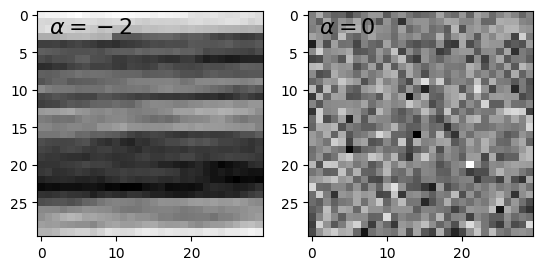

In [3]:
def create_image(noise, imgx=256, imgy=256):
    """Create an image from a 1D array of noise"""
    image = np.zeros((imgx, imgy))
    counts = np.zeros((imgx, imgy))
    for i in range(noise.size):
        x = (i // imgy) % imgx
        y = i % imgy
        image[x,y] += noise[i]
        counts[x,y] += 1
    image[counts > 0] /= counts[counts > 0]
    return image

noise, nu, ps = generate_fnoise(-2, nu0=0.01)
image = create_image(noise,imgx=30,imgy=30)
ax = pyplot.subplot(121)
pyplot.imshow(image, cmap='gray')
pyplot.text(0.05, 0.9, r'$\alpha = -2$', transform=ax.transAxes, fontsize=16)
ax = pyplot.subplot(122)
noise, nu, ps = generate_fnoise(0, nu0=0.01)
pyplot.imshow(create_image(noise,imgx=30,imgy=30), cmap='gray')
pyplot.text(0.05, 0.9, r'$\alpha = 0$', transform=ax.transAxes, fontsize=16)


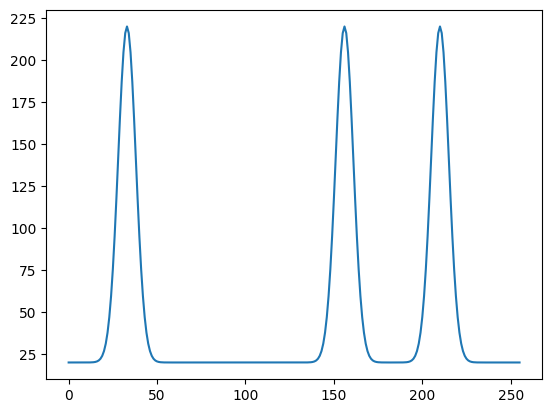

In [6]:
def generate_tsys_spikes(n_frequencies,n_spikes, Tsys0=20, amplitude=200, sigma=5):
    """Generate something that looks like the tsys spikes"""

    tsys = np.ones(n_frequencies)*Tsys0
    frequencies = np.arange(n_frequencies) 
    gaussian = lambda amplitude, offset, sigma, x: amplitude*np.exp(-0.5*((x-offset)/sigma)**2) 
    for ispike in range(n_spikes):
        idx = int(np.random.uniform(low=0,high=n_frequencies+1))

        tsys += gaussian(amplitude, idx, sigma, frequencies)

    return tsys 

n_frequencies = 256 
n_spikes = 3 
tsys_spikes = generate_tsys_spikes(n_frequencies, n_spikes)

pyplot.plot(tsys_spikes)
pyplot.xlabel('Frequency Index')
pyplot.ylabel(r'$T_\mathrm{sys}$') 
pyplot.show()

## Gain Correction algorithm 

We can define each time and frequency sample measured by COMAP as the product of the system gain and the system temperature, where the system temperature defines the thermal noise of system and the system gain defines the conversion between the arbitary voltages measured into calibrated brightness temperatures. This can be written as
$$
d_{ij} = (G_j + \delta g_{i})(T_j + \delta T_i) \approx G_j T_j + G_j\delta T_i + T_j \delta g_i,
$$
where $G_j$ is the time average gain of the system, $T_j$ is the time average system temperature (i.e., the plot above), $\delta g_i$ are time variations in $G_j$, and $\delta T_i$ are time variations in $T_j$. We are assuming that the frequency structure of $T$ and $G$ do not change in this model, and are just subject to bulk changes over time. 

Now, we actually measure the mean value of $G$ and $T$ by performing a hot-cold calibration at the start of each observation. This means we cover the receiver with a microwave absorbing vane and measure the voltage, then we compare this voltage to the temperature of the cold sky. The system temperature $T_j$ is then defined as
$$
T = (Y T_{cmb} - T_{vane})/ (1 - Y),
$$
where $Y = V_h/V_c$, and the gain is defined as 
$$
G = (V_h - V_c)/(T_vane - T_cmb) 
$$
where $T_{cmb} \approx = 2.73$K. 

Now we will normalise $d_{ij}$ by
$$
\hat{d}_{ij} = \frac{d_{ij}}{T_j G_j} - 1 = \frac{\delta T_i}{T_j} + \frac{\delta g_i}{G_j},
$$
this is the model we fit for to find the relative 1/f gain fluctuations of the receiver defined as $g_{i} = \frac{\delta g_i}{G_j}$. We have also found that assuming that the temperature fluctuations are just constant offsets isn't quite sufficient due to variations in the spectrum of real sources in the sky, for this reason we Taylor expand the first term to include a first order term resulting in this final expression
$$
\hat{d}_{ij} = g_i + \frac{\alpha_i}{T_j} + \nu\frac{\beta_i}{T_j},
$$
where we have expanded $\delta T_i$ into $\alpha_i + \nu \beta_i$, where we are fitting for the terms $\alpha_i$ and $\beta_i$.

In the current implementation of the gain correction code we solve for $g_i$, $\alpha_i$ and $\beta_i$ independently for each time sample by solving the following linear equation:
$$
\mathbf{d} = \mathbf{A} \mathbf{x}, 
$$
where $\mathbf{A}$ is the transformation matrix where each column contains:
$$
\mathbf{A}_0 = \mathbf{1}
$$
$$
\mathbf{A}_1 = \frac{1}{\mathbf{T}}
$$
$$
\mathbf{A}_2 = \frac{\nu}{\mathbf{T}}
$$
and $\mathbf{x}$ contains the parameters $g$, $\alpha$ and $\beta$.

You can solve for the maximum-likelihood estimate of $\mathbf{x}$ using
$$
\hat{\mathbf{x}} = (\mathbf{A}^T \mathbf{A})^{-1} \mathbf{A}^T \mathbf{d} 
$$

In [7]:
### Implement a simple example here 

## Goals of the gain correction portion

0) Evaluating when the gain correction fails.

We find that occassionally the gain correction can give a very poor estimate of the underlying gain fluctuations. We know this happens when the sky signal is bright and varying quickly (i.e., it is passing over a bright feature in the Galaxy), and when the atmospheric fluctuations are large. 

- Use skydips to check opacity. Look at 1/f noise statistics.
- How stable are the Tsys spikes? Are some better than others?
- How robust is the fitting between different feeds?

1) Using masks of the "valleys" in the Tsys data to improve fits  

- Masking Tsys spikes
- Averaging together samples
- Extending taylor expansion to higher orders. 

2) (Very hard!) Use measurements of the 1/f noise spectrum to improve estimate of $\hat{\mathbf{x}}$

In principle it is better to solve all of the parameters at each time ($\hat{\mathbf{x}}_i$) simultaneously. This is possible if you imagine $\hat{\mathbf{x}}$ has a length $N_{P} * N_{time} \times 1$ ($N_{time}$ being the number of samples in time). The matrix $\mathbf{A}$ becomes $  N_{time} N_{freq} \times N_{time}N_{P}$, and $\mathbf{d} = N_{time}N_{freq} \times 1$.



